In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kurtosis, skew, boxcox
from regressors import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train_filled_na.csv')
test = pd.read_csv('test_filled_na.csv')

In [3]:
train.drop('Id', axis = 1, inplace=True)

# Outlier Detection

## Train w/ dummies

In [4]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(train)

In [5]:
mask = yhat != -1

In [6]:
train = train.loc[mask, :]

In [7]:
# X = train.loc[:, train.columns != 'SalePrice']
# y = train['SalePrice']

## Drop columns with all zeros

In [8]:
allZeroCols = train.columns[(train == 0).all()].to_list()
train = train.drop(allZeroCols, axis=1)

# Log Transformations

In [9]:
def getHistograms(cols, data):
    f, axes = plt.subplots(round(len(cols)/2)+1, 2, figsize=(10,80))
    rowIdx = 0
    colIdx = 0
    for col in cols:
        if colIdx > 1:
            rowIdx = rowIdx + 1
            colIdx = 0
            
        if col == 'GarageYrBlt':
            continue
        #print(rowIdx,colIdx)
        ax = sns.histplot(x=col, data=data, ax=axes[rowIdx,colIdx]).set_title(col)
        data[col].value_counts()
        colIdx += 1
    f.tight_layout()
    

<ipython-input-9-dbdd8714fe81>:16: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  f.tight_layout()


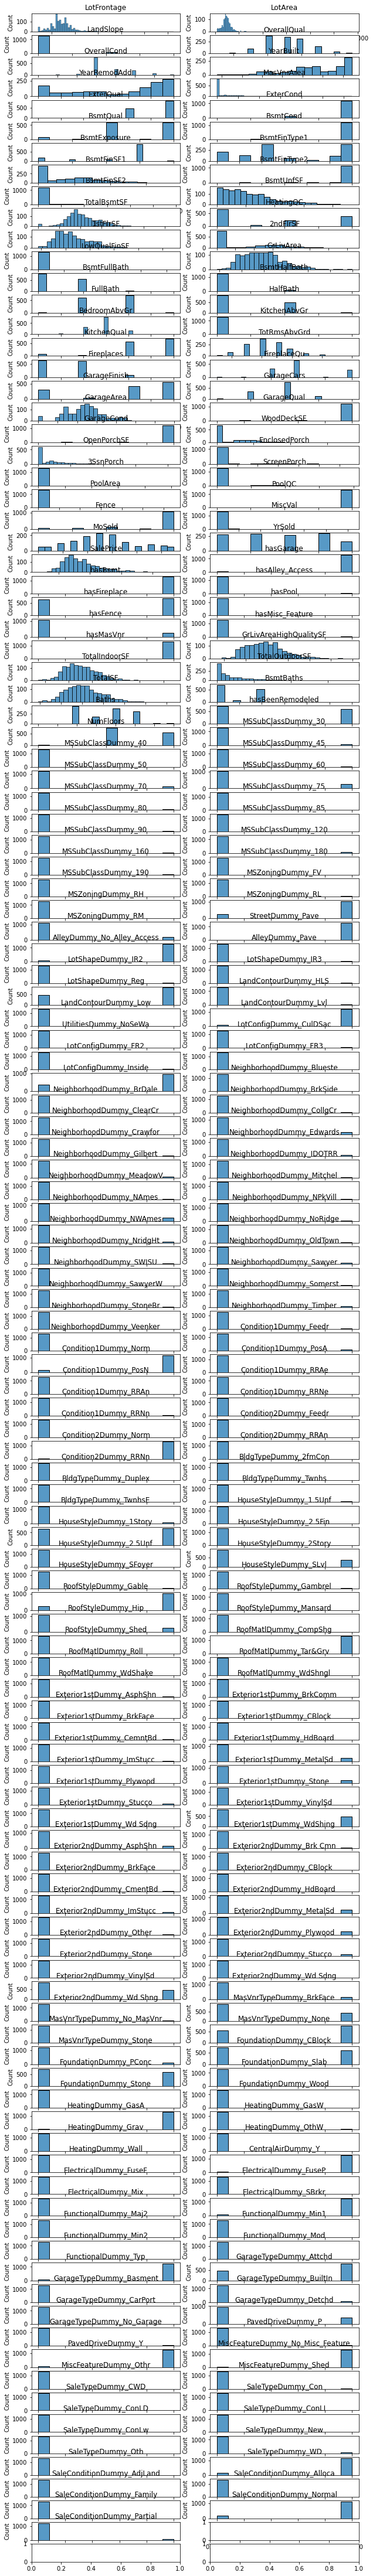

In [10]:
getHistograms(train.columns, train)

In [11]:
for col in train.columns:
    print(col, '-' ,kurtosis(train[col], bias = False, fisher=True))

LotFrontage - 11.790181154061672
LotArea - 107.63503284352194
LandSlope - 28.94452105058656
OverallQual - -0.2694252227688656
OverallCond - 0.8830038699349814
YearBuilt - -0.3967558924400585
YearRemodAdd - -1.2296506452909624
MasVnrArea - 10.30167091902748
ExterQual - 4.0434323940300345
ExterCond - 5.993497399399079
BsmtQual - -0.7090687655763728
BsmtCond - 9.443643747907108
BsmtExposure - -0.18246444296947395
BsmtFinType1 - -1.5204813009398923
BsmtFinSF1 - -0.4747957306994519
BsmtFinType2 - 9.881714768082098
BsmtFinSF2 - 21.97682214882765
BsmtUnfSF - 0.488557614900194
TotalBsmtSF - 1.8694912172114604
HeatingQC - -1.5118456778875204
1stFlrSF - 1.2849857524502237
2ndFlrSF - -0.8207924518436167
LowQualFinSF - 136.3853944559588
GrLivArea - 0.7117635476350959
BsmtFullBath - -1.0447412417402535
BsmtHalfBath - 15.860919768830279
FullBath - -1.1878679505898146
HalfBath - -1.28351837236004
BedroomAbvGr - 1.5679501421689288
KitchenAbvGr - 36.77004453750178
KitchenQual - 2.4415585736078596
TotRm

In [12]:
def logTransform(data, colsToTransform):
    for col in colsToTransform:
        data[col] = np.log1p(data[col])
        
    

In [13]:
colsToTransform = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',
                   '1stFlrSF', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'OpenPorchSF', 'EnclosedPorch',
                   '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','SalePrice']

logTransform(train, colsToTransform)

In [14]:
for col in train.columns:
    print(col, '-' ,kurtosis(train[col], bias = False, fisher=True))

LotFrontage - 2.2509602925129704
LotArea - 3.3793930941997425
LandSlope - 28.94452105058656
OverallQual - -0.2694252227688656
OverallCond - 0.8830038699349814
YearBuilt - -0.3967558924400585
YearRemodAdd - -1.2296506452909624
MasVnrArea - -1.660257888843733
ExterQual - 4.0434323940300345
ExterCond - 5.993497399399079
BsmtQual - -0.7090687655763728
BsmtCond - 9.443643747907108
BsmtExposure - -0.18246444296947395
BsmtFinType1 - -1.5204813009398923
BsmtFinSF1 - -1.4115846083279944
BsmtFinType2 - 9.881714768082098
BsmtFinSF2 - 4.631136851480559
BsmtUnfSF - 0.488557614900194
TotalBsmtSF - 36.927478441320225
HeatingQC - -1.5118456778875204
1stFlrSF - -0.2093856133696832
2ndFlrSF - -0.8207924518436167
LowQualFinSF - 83.35666423241591
GrLivArea - 0.7117635476350959
BsmtFullBath - -1.0447412417402535
BsmtHalfBath - 14.20929543337332
FullBath - -1.1878679505898146
HalfBath - -1.28351837236004
BedroomAbvGr - 1.5679501421689288
KitchenAbvGr - 32.77092837302833
KitchenQual - 2.4415585736078596
TotR

# Feature Selection

## Select K Best

In [15]:
def get_k_best(k, X, y):
    k_best = SelectKBest(f_regression, k=k).fit(X, y)
    X[X.columns[k_best.get_support()]]

    k_best_scores = zip(X.columns, k_best.scores_)
    sorted_coef_importance = sorted(list(k_best_scores),key= lambda x: x[1],reverse=True)
    sorted_coef_importance
    print(sorted_coef_importance)
    f, ax = plt.subplots(figsize=(13, 9))
    sns.barplot([x[0] for x in sorted_coef_importance[:k]], [x[1] for x in sorted_coef_importance[:k]])
    plt.xticks(rotation=90)

[('TotalSF', 3121.0077184275033), ('TotalIndoorSF', 2597.4130399996825), ('OverallQual', 2456.8467202393863), ('GrLivAreaHighQualitySF', 1521.4154452947234), ('GrLivArea', 1470.7253112345134), ('GarageCars', 1052.902778790382), ('Baths', 932.5111141054977), ('GarageArea', 849.3086779883491), ('FullBath', 786.4670630712194), ('YearBuilt', 763.4258490937336), ('ExterQual', 720.6635693683891), ('1stFlrSF', 663.0402386972203), ('BsmtQual', 632.312616233505), ('YearRemodAdd', 584.2805257114629), ('FoundationDummy_PConc', 574.0187359239014), ('KitchenQual', 557.813509272401), ('TotRmsAbvGrd', 492.3845135521796), ('hasFireplace', 413.9573613500328), ('OpenPorchSF', 401.8182866784186), ('Fireplaces', 356.99256459524383), ('HeatingQC', 320.6873975978153), ('GarageTypeDummy_Detchd', 313.08614916163543), ('GarageFinish', 311.586399906247), ('GarageTypeDummy_Attchd', 303.4073132702996), ('MSSubClassDummy_60', 264.7479315571719), ('MasVnrArea', 242.1953898662951), ('FoundationDummy_CBlock', 235.330

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


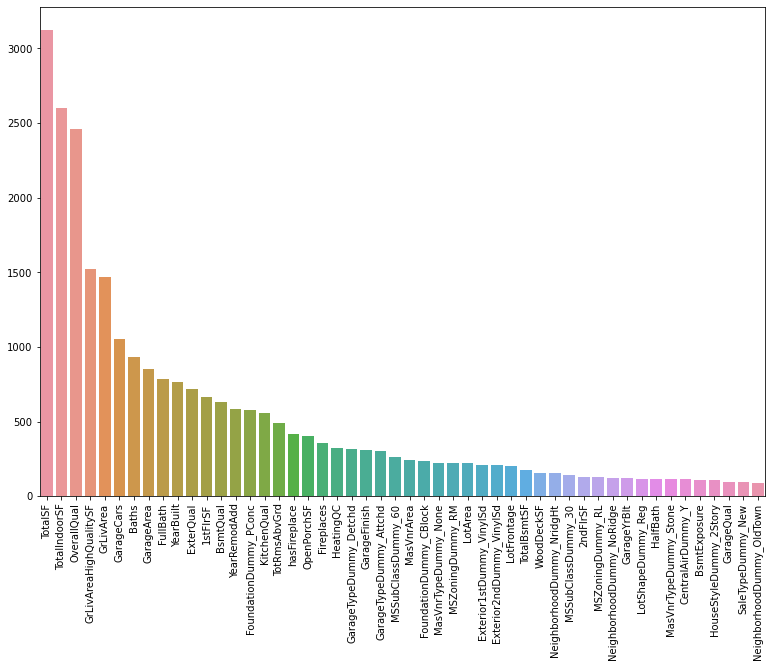

In [16]:
get_k_best(50, X=train.loc[:, train.columns != 'SalePrice'], y=train['SalePrice'])

## Model Feature Selection

In [17]:
def getFeatureImportance(num, cols, features_importances_, sort):
    
    feature_importances = zip(cols, features_importances_)
    sorted_importance = sorted(list(feature_importances),key= lambda x: abs(x[1]),reverse=False if sort == 'ascending' else True)

    f, ax = plt.subplots(figsize=(13, 9))
    sns.barplot([x[0] for x in sorted_importance[:num]], [x[1] for x in sorted_importance[:num]])
    plt.xticks(rotation=90)
    
    return sorted_importance

### Ridge Regression

In [18]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(train.loc[:, train.columns != 'SalePrice'])
X_Scaled = pd.DataFrame(X_Scaled, columns = train.columns[train.columns != 'SalePrice'])
y = train['SalePrice']

In [19]:
model = Ridge()
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,50,75,100,1000,2000]}
gridRidge = GridSearchCV(model, param_grid=params, cv=5)
gridRidge.fit(X_Scaled, y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                                   1000, 2000]})

In [20]:
gridRidge.cv_results_

{'mean_fit_time': array([0.03032951, 0.00678425, 0.00778174, 0.00757117, 0.00749207,
        0.00676003, 0.00540857, 0.00505452, 0.00507298, 0.00501223,
        0.00493064]),
 'std_fit_time': array([3.84879226e-02, 4.99415902e-04, 6.57287947e-04, 7.80427526e-04,
        6.10607492e-04, 4.08736529e-04, 5.65827606e-04, 1.40288977e-04,
        1.57829109e-04, 8.56161616e-05, 4.75316522e-04]),
 'mean_score_time': array([0.00386839, 0.00333982, 0.00398588, 0.00408683, 0.00399289,
        0.00339742, 0.00277219, 0.00270185, 0.00266528, 0.00252419,
        0.0028183 ]),
 'std_score_time': array([4.47661581e-04, 3.17382626e-04, 2.44748766e-04, 1.52464206e-04,
        3.93924830e-04, 2.85020109e-04, 1.13983791e-04, 9.39028577e-05,
        9.48215598e-05, 1.85431138e-04, 1.65327179e-04]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100, 1000,
                    2000],
              mask=[False, False, False, False, False, False, False, False,
                    

In [21]:
gridRidge.best_params_

{'alpha': 100}

In [22]:
gridRidge.best_score_

0.907208303550663

In [23]:
gridRidge.best_estimator_.coef_

array([ 6.91488751e-03,  2.75614932e-02,  2.29414738e-03,  4.95485803e-02,
        3.48301917e-02,  3.53822972e-02,  1.35622847e-02,  1.96617241e-03,
       -4.83963724e-03,  1.27910782e-03, -8.79106009e-03,  7.07218508e-03,
       -4.42137175e-03, -2.54732742e-03,  1.24423959e-02,  1.90731233e-03,
       -1.38492221e-03, -1.25546442e-02,  1.28533760e-02, -9.87162219e-03,
        2.38487727e-02,  1.26741737e-02,  6.94228846e-03,  2.66712061e-02,
        8.63287897e-03, -9.44770940e-04,  9.68968906e-03,  7.31396534e-03,
       -2.04219058e-03, -1.19050146e-02, -1.38641546e-02,  1.47620468e-04,
        7.09840218e-03, -4.26432284e-03,  1.66686294e-03, -4.75361254e-03,
        1.39488271e-02,  9.10660588e-03,  5.98640058e-03, -3.02161919e-03,
        1.07906555e-02,  6.01116600e-03, -1.83758078e-03, -1.94279225e-03,
        6.23620537e-03,  3.35254145e-03,  3.02075561e-03,  5.50843086e-03,
       -1.19875926e-03, -1.49889794e-03, -2.54800998e-03,  1.37967569e-03,
       -4.44285772e-03,  

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[('OverallQual', 0.0495485803343143),
 ('YearBuilt', 0.035382297198858874),
 ('OverallCond', 0.03483019173733091),
 ('GrLivAreaHighQualitySF', 0.034169775275837394),
 ('TotalOutdoorSF', 0.030877416566569553),
 ('LotArea', 0.02756149323017166),
 ('GrLivArea', 0.02667120608959427),
 ('1stFlrSF', 0.023848772713157048),
 ('SaleConditionDummy_Family', 0.02271645747432303),
 ('hasMasVnr', 0.022199057382603932),
 ('Condition1Dummy_Feedr', 0.017357473150660722),
 ('NeighborhoodDummy_CollgCr', 0.017349054318400493),
 ('NumFloors', -0.016920185695597136),
 ('SaleConditionDummy_Normal', 0.015574232617365305),
 ('FunctionalDummy_Mod', 0.0148793920698881),
 ('NeighborhoodDummy_Somerst', 0.0144925373397193),
 ('NeighborhoodDummy_NoRidge', 0.01427354307931256),
 ('GarageCars', 0.013948827061316173),
 ('KitchenQual', -0.013864154636754195),
 ('MSZoningDummy_RH', 0.013641256158512857),
 ('YearRemodAdd', 0.013562284734957655),
 ('Exterior1stDummy_BrkComm', 0.013464490066468826),
 ('MSSubClassDummy_190',

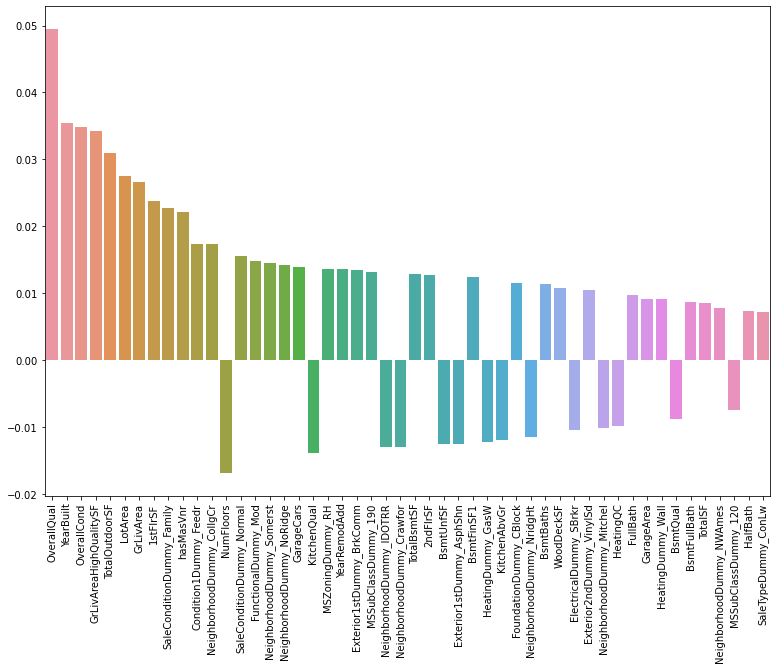

In [24]:
getFeatureImportance(50, train.columns, gridRidge.best_estimator_.coef_,'descending')

### Lasso Regression

In [25]:
model = Lasso()
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,50,75,100,1000,2000],'max_iter':[1000]}
gridLasso = GridSearchCV(model, param_grid=params, cv=5)
gridLasso.fit(X_Scaled, y)

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.062451007460682106, tolerance: 0.013286951577939956
  model = cd_fast.enet_coordinate_descent(
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09810955185084147, tolerance: 0.012780897408879426
  model = cd_fast.enet_coordinate_descent(
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1269318744403929, tolerance: 0.013363045731922018
  model = cd_fast.enet_coordinate_descent(
/Users/baileyrusso/opt/anaconda3/lib/pyt

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                                   1000, 2000],
                         'max_iter': [1000]})

In [26]:
gridLasso.cv_results_

{'mean_fit_time': array([0.135918  , 0.11651111, 0.01608047, 0.00575943, 0.00442276,
        0.0043539 , 0.00557284, 0.00676918, 0.00736179, 0.00797987,
        0.00717225]),
 'std_fit_time': array([1.24791734e-02, 1.32215801e-02, 2.74894861e-03, 2.59496271e-04,
        9.43338412e-05, 1.37221490e-04, 6.55221007e-04, 7.93643947e-04,
        4.40052617e-04, 6.73125499e-04, 4.24259591e-04]),
 'mean_score_time': array([0.00322042, 0.00410876, 0.00322971, 0.0025702 , 0.00269628,
        0.00269227, 0.00329976, 0.0040606 , 0.00431442, 0.00421052,
        0.00423379]),
 'std_score_time': array([1.01764680e-03, 2.65861865e-04, 5.79294990e-04, 7.48135163e-05,
        1.03095678e-04, 9.53566307e-05, 2.56073159e-04, 5.28858491e-04,
        5.36613691e-04, 5.22152199e-04, 2.67731279e-04]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100, 1000,
                    2000],
              mask=[False, False, False, False, False, False, False, False,
                    

In [27]:
gridLasso.best_params_

{'alpha': 0.001, 'max_iter': 1000}

In [28]:
gridLasso.best_score_

0.9108942852542636

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[('TotalOutdoorSF', 0.07105931761941149),
 ('YearBuilt', 0.06255910977177992),
 ('OverallQual', 0.06193798698882172),
 ('GrLivArea', 0.04688548106698944),
 ('OverallCond', 0.0409338872433836),
 ('LotArea', 0.035558231471814375),
 ('GrLivAreaHighQualitySF', 0.03143696179949843),
 ('SaleConditionDummy_Normal', 0.025263403715871862),
 ('SaleConditionDummy_Family', 0.023902288677358028),
 ('NeighborhoodDummy_CollgCr', 0.02201690512072176),
 ('BsmtUnfSF', -0.021290254896648635),
 ('Condition1Dummy_Feedr', 0.016884664891399673),
 ('BsmtBaths', 0.015033638518162966),
 ('HeatingDummy_GasW', -0.014403659644499234),
 ('GarageCars', 0.014267983652549103),
 ('FunctionalDummy_Mod', 0.01406709555591398),
 ('KitchenQual', -0.013543050031746795),
 ('NumFloors', -0.01352448572697428),
 ('NeighborhoodDummy_NoRidge', 0.013406177440745789),
 ('NeighborhoodDummy_Somerst', 0.012492455240820459),
 ('KitchenAbvGr', -0.012447185856961617),
 ('Exterior1stDummy_BrkComm', 0.012366223424817037),
 ('Exterior1stDumm

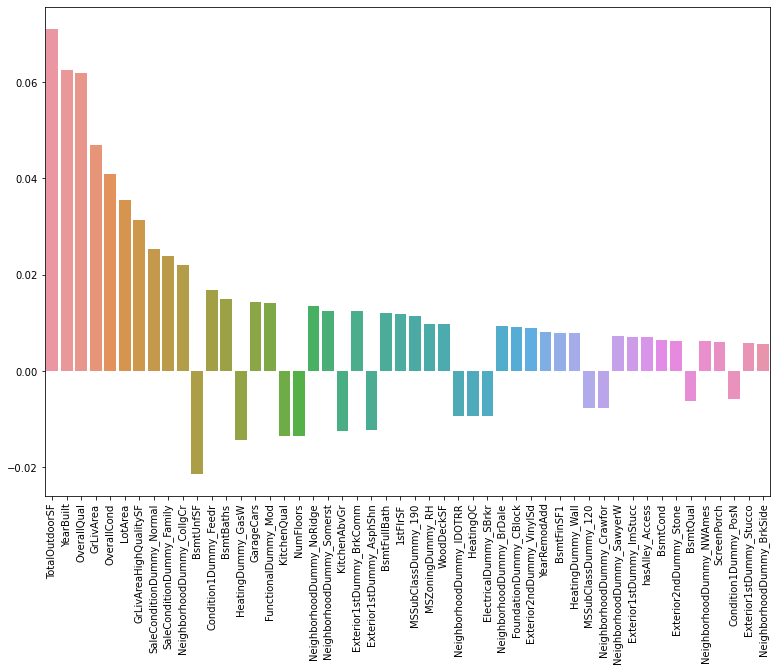

In [29]:
getFeatureImportance(50, train.columns, gridLasso.best_estimator_.coef_, '')

## Value Counts

In [30]:
train_org = pd.read_csv('train.csv')

In [31]:
def getValueCounts(cols, data):
    f, axes = plt.subplots(round(len(cols)/2)+1, 2, figsize=(10,80))
    rowIdx = 0
    colIdx = 0
    for col in cols:
        if colIdx > 1:
            rowIdx = rowIdx + 1
            colIdx = 0
        value_counts = data[col].value_counts()
        ax = sns.barplot(x=value_counts.index, y=value_counts, data=data, ax=axes[rowIdx,colIdx]).set_title(col)
        colIdx += 1
    f.tight_layout()

<ipython-input-32-805f6aa5abec>:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  cat_cols = train_org.columns[train_org.dtypes == 'object'] | train_org.columns[train_org.columns == 'MSSubClass']


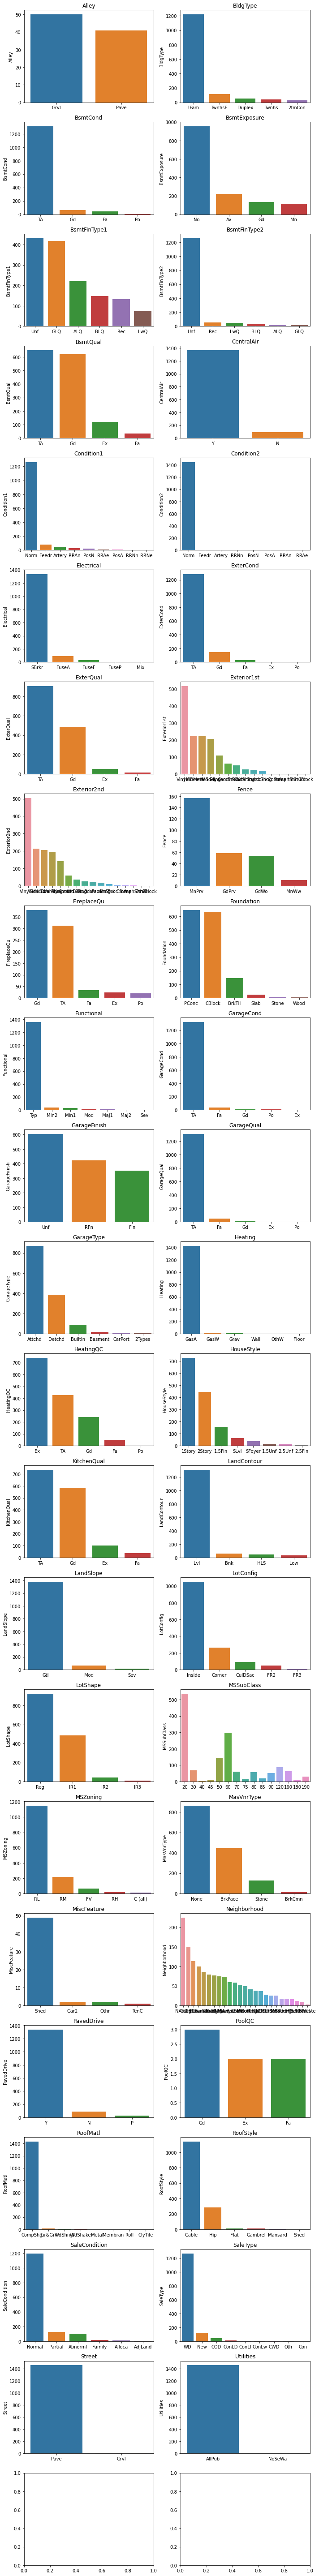

In [32]:
cat_cols = train_org.columns[train_org.dtypes == 'object'] | train_org.columns[train_org.columns == 'MSSubClass']
getValueCounts(cat_cols, train_org)

In [33]:
colsToDrop = ['BldgType','BsmtCond','BsmtFinType2','CentralAir','Condition1','Condition2','Electrical',
              'ExterCond','Functional','GarageCond','GarageQual','Heating','LandContour','LandSlope',
              'MiscFeature','PavedDrive','RoofMatl','Street','Utilities','SaleType','MSSubClass']

In [34]:
for col in colsToDrop:
    train = train[train.columns.drop(list(train.filter(regex=col)))]

In [35]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(train.loc[:, train.columns != 'SalePrice'])
X_Scaled = pd.DataFrame(X_Scaled, columns = train.columns[train.columns != 'SalePrice'])
y = train['SalePrice']

## Ridge on Subset

In [36]:
model = Ridge()
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,50,75,100,1000,2000],'max_iter':[1000]}
gridRidge = GridSearchCV(model, param_grid=params, cv=5)
gridRidge.fit(X_Scaled, y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                                   1000, 2000],
                         'max_iter': [1000]})

In [37]:
gridRidge.best_score_

0.9042610828046508

## Lasso on Subset

In [38]:
model = Lasso()
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,50,75,100,1000,2000],'max_iter':[1000]}
gridLasso = GridSearchCV(model, param_grid=params, cv=5)
gridLasso.fit(X_Scaled, y)

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04276468839342851, tolerance: 0.012780897408879426
  model = cd_fast.enet_coordinate_descent(
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033009887364110035, tolerance: 0.013363045731922018
  model = cd_fast.enet_coordinate_descent(
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11769041450860485, tolerance: 0.013341213908912025
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                                   1000, 2000],
                         'max_iter': [1000]})

In [39]:
gridLasso.best_score_

0.9069366675768837

## Correlation between variables

### Correlation Matrix

In [40]:
corr = X_Scaled.corr()

In [41]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
mostCorrelatedFeat = get_top_abs_correlations(corr, 1000)


Top Absolute Correlations


In [42]:
mostCorrelatedFeat.head(50)

hasMasVnr                 MasVnrTypeDummy_No_MasVnr     1.000000
hasAlley_Access           AlleyDummy_No_Alley_Access    1.000000
hasGarage                 GarageTypeDummy_No_Garage     1.000000
Exterior1stDummy_CBlock   Exterior2ndDummy_CBlock       1.000000
PoolArea                  hasPool                       0.999998
Exterior1stDummy_VinylSd  Exterior2ndDummy_VinylSd      0.999197
Exterior1stDummy_MetalSd  Exterior2ndDummy_MetalSd      0.999021
Exterior1stDummy_CemntBd  Exterior2ndDummy_CmentBd      0.998778
MiscVal                   hasMisc_Feature               0.998619
GrLivArea                 GrLivAreaHighQualitySF        0.998169
PoolArea                  PoolQC                        0.997668
PoolQC                    hasPool                       0.997530
GarageYrBlt               GarageTypeDummy_No_Garage     0.996274
                          hasGarage                     0.996274
TotalIndoorSF             TotalSF                       0.995784
MasVnrArea               

In [43]:
colsToDrop = ['Exterior2nd']
for col in colsToDrop:
    train = train[train.columns.drop(list(train.filter(regex=col)))]

In [44]:
X = train.loc[:, train.columns != 'SalePrice']

### Variance Inflation Factor

In [45]:
constant = np.ones((X.shape[0], 1))
X['constant'] = constant

In [46]:
vifs = zip(X.columns, [variance_inflation_factor(X.values, i) for i in range(len(X.columns))])

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [47]:
list(vifs)

[('LotFrontage', 4.427108039366632),
 ('LotArea', 4.856665372934281),
 ('OverallQual', 4.539954611112168),
 ('OverallCond', 2.006151518679635),
 ('YearBuilt', 12.865676352587236),
 ('YearRemodAdd', 3.51031824246448),
 ('MasVnrArea', 24.775366794165166),
 ('ExterQual', 2.9972200293173765),
 ('BsmtQual', 2.9198473643488514),
 ('BsmtExposure', 1.8464233714097629),
 ('BsmtFinType1', 3.8154054326064517),
 ('BsmtFinSF1', 8.843785065531893),
 ('BsmtFinSF2', 1.4691238322536222),
 ('BsmtUnfSF', 7.9226933172312775),
 ('TotalBsmtSF', 301.0839708386743),
 ('1stFlrSF', 63.59429862316727),
 ('2ndFlrSF', 105.64007493255222),
 ('LowQualFinSF', 8.50334075790506),
 ('GrLivArea', 431.1851234693631),
 ('BsmtFullBath', 9328.954731932512),
 ('BsmtHalfBath', 480.07914055268196),
 ('FullBath', inf),
 ('HalfBath', inf),
 ('BedroomAbvGr', 2.9347016434418514),
 ('KitchenAbvGr', 1.72738877723085),
 ('KitchenQual', 2.1771573674547553),
 ('TotRmsAbvGrd', 5.14427007587307),
 ('Fireplaces', 7.490437282628703),
 ('Fir

In [48]:
X[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,6.561031,0.000000,150,6.753438
1,6.886532,0.000000,284,7.141245
2,6.188264,0.000000,434,6.825460
3,5.379897,0.000000,540,6.629363
4,6.486161,0.000000,490,7.044033
...,...,...,...,...
1454,6.018593,0.000000,811,7.108244
1455,0.000000,0.000000,953,6.860664
1456,6.673298,5.099866,589,7.341484
1458,3.912023,6.937314,0,6.983790


In [49]:
X[['GrLivArea','1stFlrSF','2ndFlrSF','LowQualFinSF']]

,GrLivArea,1stFlrSF,2ndFlrSF,LowQualFinSF
0,1710,6.753438,854,0.0
1,1262,7.141245,0,0.0
2,1786,6.825460,866,0.0
3,1717,6.869014,756,0.0
4,2198,7.044033,1053,0.0
...,...,...,...,...
1454,1221,7.108244,0,0.0
1455,1647,6.860664,694,0.0
1456,2073,7.637234,0,0.0
1458,1078,6.983790,0,0.0


In [50]:
train = train.drop(['GrLivArea','TotalBsmtSF','OverallQual','GarageArea','PoolArea','PoolQC'], axis=1)

In [51]:
X_Scaled = train.loc[:,train.columns != 'SalePrice']

### Variance Inflation Factor on Subset

In [52]:
vifs = zip(X.columns, [variance_inflation_factor(X.values, i) for i in range(len(X.columns))])

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [53]:
list(vifs)

[('LotFrontage', 4.427108039366632),
 ('LotArea', 4.856665372934281),
 ('OverallQual', 4.539954611112168),
 ('OverallCond', 2.006151518679635),
 ('YearBuilt', 12.865676352587236),
 ('YearRemodAdd', 3.51031824246448),
 ('MasVnrArea', 24.775366794165166),
 ('ExterQual', 2.9972200293173765),
 ('BsmtQual', 2.9198473643488514),
 ('BsmtExposure', 1.8464233714097629),
 ('BsmtFinType1', 3.8154054326064517),
 ('BsmtFinSF1', 8.843785065531893),
 ('BsmtFinSF2', 1.4691238322536222),
 ('BsmtUnfSF', 7.9226933172312775),
 ('TotalBsmtSF', 301.0839708386743),
 ('1stFlrSF', 63.59429862316727),
 ('2ndFlrSF', 105.64007493255222),
 ('LowQualFinSF', 8.50334075790506),
 ('GrLivArea', 431.1851234693631),
 ('BsmtFullBath', 9328.954731932512),
 ('BsmtHalfBath', 480.07914055268196),
 ('FullBath', inf),
 ('HalfBath', inf),
 ('BedroomAbvGr', 2.9347016434418514),
 ('KitchenAbvGr', 1.72738877723085),
 ('KitchenQual', 2.1771573674547553),
 ('TotRmsAbvGrd', 5.14427007587307),
 ('Fireplaces', 7.490437282628703),
 ('Fir

### Correlation Matrix on Subset

In [54]:
corr = X_Scaled.corr()

In [55]:
mostCorrelatedFeat = get_top_abs_correlations(corr, 1000)
mostCorrelatedFeat.head(50)

hasAlley_Access           AlleyDummy_No_Alley_Access    1.000000
hasGarage                 GarageTypeDummy_No_Garage     1.000000
hasMasVnr                 MasVnrTypeDummy_No_MasVnr     1.000000
MiscVal                   hasMisc_Feature               0.998674
GarageYrBlt               GarageTypeDummy_No_Garage     0.996466
                          hasGarage                     0.996466
TotalIndoorSF             TotalSF                       0.996216
MasVnrArea                MasVnrTypeDummy_None          0.994671
Fence                     hasFence                      0.992441
BsmtFullBath              BsmtBaths                     0.990839
Fireplaces                hasFireplace                  0.988363
RoofStyleDummy_Gable      RoofStyleDummy_Hip            0.984891
FullBath                  Baths                         0.975746
MSZoningDummy_FV          NeighborhoodDummy_Somerst     0.968245
BsmtFinType1              BsmtFinSF1                    0.966513
TotRmsAbvGrd             

In [56]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(train.loc[:, train.columns != 'SalePrice'])
X_Scaled = pd.DataFrame(X_Scaled, columns = train.columns[train.columns != 'SalePrice'])
y = train['SalePrice']

In [57]:
model = Lasso()
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,50,75,100,1000,2000],'max_iter':[1000]}
gridLasso = GridSearchCV(model, param_grid=params, cv=5)
gridLasso.fit(X_Scaled, y)


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                                   1000, 2000],
                         'max_iter': [1000]})

In [58]:
list(zip(X_Scaled.columns,gridLasso.best_estimator_.coef_))

[('LotFrontage', 0.003945630786908636),
 ('LotArea', 0.03294751848320923),
 ('OverallCond', 0.054608500639140974),
 ('YearBuilt', 0.08839131875738053),
 ('YearRemodAdd', 0.011012208606934103),
 ('MasVnrArea', 0.0),
 ('ExterQual', -0.0065220841648576736),
 ('BsmtQual', -0.007427619573232865),
 ('BsmtExposure', -0.00576407720232215),
 ('BsmtFinType1', -0.0),
 ('BsmtFinSF1', 0.00926347204705625),
 ('BsmtFinSF2', -0.00534186938037747),
 ('BsmtUnfSF', -0.018443268515583745),
 ('1stFlrSF', 0.03901835042535057),
 ('2ndFlrSF', 0.03772669934398791),
 ('LowQualFinSF', 0.009934394950403288),
 ('BsmtFullBath', 0.010978437483978656),
 ('BsmtHalfBath', -0.0),
 ('FullBath', 0.0),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', -0.0),
 ('KitchenAbvGr', -0.019261742259272862),
 ('KitchenQual', -0.017846617961674267),
 ('TotRmsAbvGrd', 0.0),
 ('Fireplaces', 0.012645077273800598),
 ('FireplaceQu', -0.006951436996336471),
 ('GarageYrBlt', 0.007443033498552322),
 ('GarageFinish', -0.006605720436852272),
 ('GarageCar

In [59]:
stats.summary(gridLasso.best_estimator_, X_Scaled, y)

Residuals:
    Min      1Q  Median     3Q    Max
-0.4154 -0.0554 -0.0038 0.0451 0.6527


Coefficients:
             Estimate                  Std. Error            t value   p value
_intercept  12.018120  0.0029760000+0.0000000000j  4037.9748-0.0000j  0.000000
x1           0.003946  0.0052170000+0.0000000000j   0.75620-0.00000j  0.449646
x2           0.032948  0.0054000000-0.0000050000j   6.10140+0.00560j  0.000000
x3           0.054609  0.0035980000+0.0000020000j  15.17760-0.00850j  0.000000
x4           0.088391  0.0087570000+0.0000080000j  10.09430-0.00910j  0.000000
x5           0.011012  0.0046920000-0.0000010000j   2.34690+0.00030j  0.019079
x6           0.000000  0.0113360000+0.0000020000j   0.00000+0.00000j  1.000000
x7          -0.006522  0.0044770000+0.0000110000j  -1.45660+0.00350j  0.145455
x8          -0.007428  0.0044720000-0.0000000000j  -1.66100-0.00020j  0.096948
x9          -0.005764  0.0035210000-0.0000030000j  -1.63690-0.00120j  0.101900
x10         -0.000000  0.004